<a href="https://colab.research.google.com/github/maanassiraj/Gesture_Recognition/blob/main/Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the neccessary libraries

In [1]:
import numpy as np
import pandas as pd
import os
from imageio import imread
from skimage.transform import resize
import datetime
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, TimeDistributed, GRU, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.backend import clear_session
import random as rn

Set the random seed so that the results don't vary drastically each time the code is run

In [2]:
np.random.seed(100)
rn.seed(100)
tf.random.set_seed(100)

Download and unzip the dataset

In [3]:
!gdown https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
!unzip /content/Project_data.zip

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

In [4]:
!rm /content/Project_data.zip

Folder names for the training and validation data are read into train_doc and val_doc respectively. Set the batch size such that GPU memory is utilized to its full capacity

In [5]:
train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())
batch_size = 50

In [6]:
class_label = [folder.split(";")[2].strip("\n") for folder in train_doc]
pd.Series(class_label).value_counts()

1    137
3    137
0    136
2    130
4    123
dtype: int64

There is no class imbalance as the no of samples is almost the same for each class. Hence accuracy can used as a metric to evaluate the performance of the model

## Generator

*   Build a data generator that generates batches of videos of size = batch_size
*   Since all images don't have the same shape, they need to be resized.
*   Not all frames of each video need to be included in the training data
*   The images need to be normalised before they are fed to the model



 

In [7]:
img_idx = np.arange(0, 30, 2) # list of indices of the frames that you want to use from each video
def generator(source_path, folder_list, batch_size, ablation = None):
    print( 'Source path = ', source_path, 'batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list) # shuffle the data for each epoch
        if ablation is None :
          num_batches = len(t) // batch_size # calculate the number of batches
          for batch in range(num_batches): # iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), 120, 120, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image = resize(image, (120, 120, 3)) # resize each image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.mean(image[:,:,0])) #centering the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.mean(image[:,:,1])) #centering the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.mean(image[:,:,2])) #centering the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels 
          
          # for the remaining sequences
          if len(t) % batch_size != 0 : 
            rem_data = len(t) % batch_size
            batch_data = np.zeros((rem_data, len(img_idx), 120, 120, 3))
            batch_labels = np.zeros((rem_data, 5))
            for folder in range(rem_data) :
              imgs = os.listdir(source_path + '/' + t[folder + (num_batches * batch_size)].strip().split(";")[0])
              for idx, item in enumerate(img_idx) :
                image = imread(source_path+'/'+ t[folder + (num_batches * batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image = resize(image, (120, 120, 3))
                batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.mean(image[:,:,0])) #centering the image
                batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.mean(image[:,:,1])) #centering the image
                batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.mean(image[:,:,2])) #centering the image
              batch_labels[folder, int(t[folder + (num_batches * batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels     

            
        else :
          num_batches = ablation // batch_size
          for batch in range(num_batches) :
            batch_data = np.zeros((batch_size, len(img_idx), 120, 120, 3))
            batch_labels = np.zeros((batch_size, 5))
            for folder in range(batch_size) :
              imgs = os.listdir(source_path + '/' + t[folder + (batch*batch_size)].strip().split(";")[0])
              for idx, item in enumerate(img_idx) :
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image = resize(image, (120, 120, 3))
                batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.mean(image[:,:,0])) #centering the image
                batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.mean(image[:,:,1])) #centering the image
                batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.mean(image[:,:,2])) #centering the image
              batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
          yield batch_data, batch_labels
        
          if ablation % batch_size != 0 :
            rem_data = ablation % batch_size
            batch_data = np.zeros((rem_data, len(img_idx), 120, 120, 3))
            batch_labels = np.zeros((rem_data, 5))
            for folder in range(rem_data) :
              imgs = os.listdir(source_path + '/' + t[folder + (num_batches * batch_size)].strip().split(";")[0])
              for idx, item in enumerate(img_idx) :
                image = imread(source_path+'/'+ t[folder + (num_batches * batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image = resize(image, (120, 120, 3))
                batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.mean(image[:,:,0])) #centering the image
                batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.mean(image[:,:,1])) #centering the image
                batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.mean(image[:,:,2])) #centering the image
              batch_labels[folder, int(t[folder + (num_batches * batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels     
        


In [8]:
train_path = '/content/Project_data/train'
val_path = '/content/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


Looking at a random frame from a random video generated by the generator

Source path =  /content/Project_data/train batch size = 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


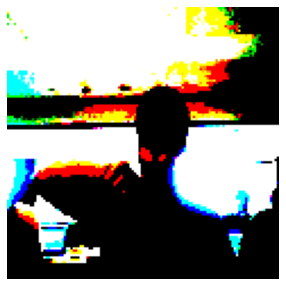

In [9]:
batch_data, batch_labels = next(generator(train_path, train_doc, batch_size))
plt.figure(figsize = (5, 5))
vid_rand = np.random.randint(batch_size)
frame_rand = np.random.randint(len(img_idx))
plt.imshow(batch_data[vid_rand, frame_rand, :, :, :])
plt.axis("off")
plt.show()

## Modelling
### Design the model in such a way that its accuracy is high with least number of parameters, so that it can fit in the memory of the webcam and respond instantly in real time scenarios

### Defining a function that trains a model

It does the following :

*   Defines the optimiser
*   Compiles the model
*   Defines callbacks such as ModelCheckpoint for saving the best model at the end of every epoch and ReduceLROnPlateau reducing the learning rate once the val_loss plateaus
*   Creates the generator objects for the training data and validation data
*   Calls the fit() method of the keras model
*   Plots the validation accuracy and training accuracy across epochs

In [10]:
def model_training(model, lr, patience, factor, num_epochs = 30) :
  adam = optimizers.Adam(learning_rate = lr) # define the optimizer
  model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy']) # compile the model

  train_generator = generator(train_path, train_doc, batch_size)# create the generator objects for training and validation data
  val_generator = generator(val_path, val_doc, batch_size)
  
  curr_dt_time = datetime.datetime.now()
  model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
  if not os.path.exists(model_name):
    os.mkdir(model_name)
        
  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'  # define the name of the file where the model will be saved

  # define callbacks 
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = 'epoch')
  LR = ReduceLROnPlateau(patience = patience, factor = factor, verbose = 1) 
  callbacks_list = [checkpoint, LR]

  if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
  else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
  else:
    validation_steps = (num_val_sequences//batch_size) + 1

  history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=[callbacks_list], validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0) # train the model
  
  plt.figure(figsize = (8, 8))
  plt.plot(range(num_epochs), history.history["categorical_accuracy"])
  plt.plot(range(num_epochs), history.history["val_categorical_accuracy"])  # plot train and validation accuracies
  plt.legend(labels = ["train", "validation"])
  plt.show()

### model_1 : CONV3D Model

In [11]:
clear_session()
#write your model here
model_1 = Sequential()
model_1.add(Conv3D(32, 3, activation = "elu", input_shape = (len(img_idx), 120, 120, 3), padding = "same"))
model_1.add(MaxPooling3D(padding = "same"))
model_1.add(BatchNormalization())
model_1.add(Conv3D(64, 3, activation = "elu", padding = "same"))
model_1.add(MaxPooling3D(padding = "same"))
model_1.add(BatchNormalization())
model_1.add(Conv3D(128, 3, activation = "elu"))
model_1.add(MaxPooling3D())
model_1.add(BatchNormalization())
model_1.add(Flatten())
model_1.add(Dense(256, activation = "elu"))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.75))
model_1.add(Dense(512, activation = "elu"))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.75))
model_1.add(Dense(5, activation = "softmax"))
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 60, 60, 32)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 8, 60, 60, 32)    128       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 60, 60, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 4, 30, 30, 64)    0         
 3D)                                                             
                                                        

### Training model_1

Source path =  /content/Project_data/train batch size = 50
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 2.6931 - categorical_accuracy: 0.3243Source path =  /content/Project_data/val batch size = 50

Epoch 00001: val_loss improved from inf to 171.40234, saving model to model_init_2021-11-1904_01_26.820645/model-00001-2.69314-0.32428-171.40234-0.23000.h5
14/14 [==============================] - 168s 10s/step - loss: 2.6931 - categorical_accuracy: 0.3243 - val_loss: 171.4023 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 1.9168 - categorical_accuracy: 0.4887
Epoch 00002: val_loss improved from 171.40234 to 154.02832, saving model to model_init_2021-11-1904_01_26.820645/model-00002-1.91681-0.48869-154.02832-0.19000.h5
14/14 [==============================] - 149s 11s/step - loss: 1.9168 - categorical_accuracy: 0.4887 - val_loss: 154.0283 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/30
14/

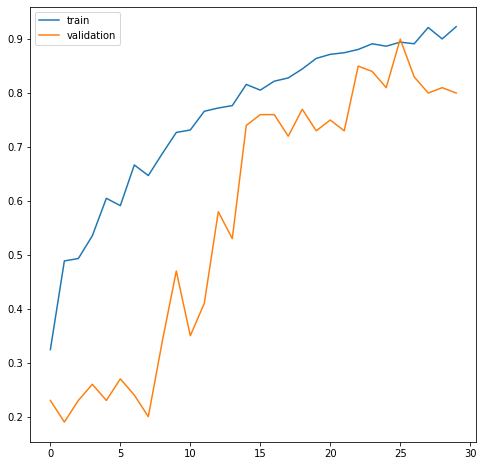

In [12]:
model_training(model_1, lr = 0.001, patience = 1, factor = 0.8)

### model_2 : CNN_GRU Model

In [19]:
clear_session()

resnet = ResNet50(include_top = False, weights = 'imagenet', input_shape = (120, 120, 3))
output = resnet.layers[-1].output
output = Flatten()(output)

resnet = Model(resnet.input, output)

for layer in resnet.layers :
  layer.trainable = False

model_2 = Sequential()
model_2.add(Input(shape = (len(img_idx), 120, 120, 3)))
model_2.add(TimeDistributed(resnet))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(GRU(64, return_sequences = True))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(GRU(32))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))
model_2.add(Dense(16, activation = "elu"))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))
model_2.add(Dense(5, activation = "softmax"))
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 32768)        23587712  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 32768)        131072    
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 15, 64)            6304128   
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 64)           256       
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                        

### Training model_2

Source path =  /content/Project_data/train batch size = 50
Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 1.8814 - categorical_accuracy: 0.3243Source path =  /content/Project_data/val batch size = 50

Epoch 00001: val_loss improved from inf to 1.03830, saving model to model_init_2021-11-1907_56_10.200614/model-00001-1.88143-0.32428-1.03830-0.69000.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


14/14 [==============================] - 151s 11s/step - loss: 1.8814 - categorical_accuracy: 0.3243 - val_loss: 1.0383 - val_categorical_accuracy: 0.6900 - lr: 0.0010
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 1.4420 - categorical_accuracy: 0.4284
Epoch 00002: val_loss improved from 1.03830 to 0.90967, saving model to model_init_2021-11-1907_56_10.200614/model-00002-1.44203-0.42836-0.90967-0.75000.h5
14/14 [==============================] - 147s 11s/step - loss: 1.4420 - categorical_accuracy: 0.4284 - val_loss: 0.9097 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 3/20
14/14 [==============================] - ETA: 0s - loss: 1.2281 - categorical_accuracy: 0.5309
Epoch 00003: val_loss improved from 0.90967 to 0.85034, saving model to model_init_2021-11-1907_56_10.200614/model-00003-1.22806-0.53092-0.85034-0.71000.h5
14/14 [==============================] - 143s 11s/step - loss: 1.2281 - categorical_accuracy: 0.5309 - val_loss: 0.8503 - val_categorical_ac

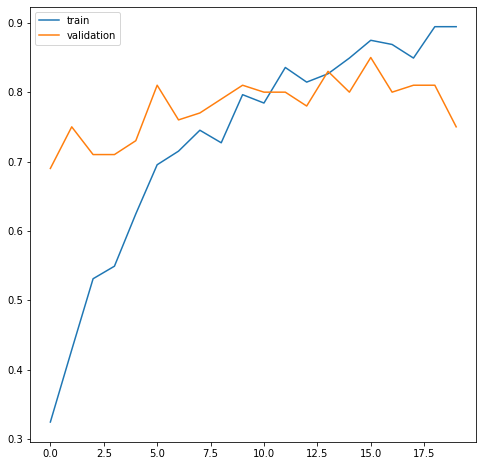

In [21]:
model_training(model_2, lr = 0.001, patience = 1, factor = 0.8, num_epochs = 20)



*   model_1 and model_2 have similar validation accuracies
*   model_2 has around 5 times the no of parameters as model_1

Since the model has to be deployed in a real world scenario, it is better to go with model_1(CONV3D model) which has a considerably lower no of parameters